# Evaluate "LLM as a Judge" for Summarization 2.2

In [4]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns

# Configure Matplotlib for inline display
%matplotlib inline

In [2]:
# Choose which llm-as-a-judge data to evaluate
common_path = "../../data/evaluations/"

llm_judge_filename_start = "summaries_1.0_evaluation_2.csv"
llm_judge_filename_end = "summaries_1.0_evaluation_2.2_split.csv"

llm_data_start = pd.read_csv(common_path + llm_judge_filename_start)
llm_data_end = pd.read_csv(common_path + llm_judge_filename_end)

# This is from our sweat blood and tears
human_data = pd.read_csv(common_path + '2024-07-24-human-judge-summarization.csv')

question_categories = {
    "report_content": ["intro_patient_present", "current_symptoms_present", "vital_signs_present", "medications_present", "summary_overview_present"],
    "report_accuracy": ["current_symptoms_agree", "vital_signs_agree", "medications_agree"],
    "report_quality": ["no_diagnose"],
}

# create a reverse mapping for renaming later
criteria_to_category_map = {criterion: category for category, criteria in question_categories.items() for criterion in criteria}

feature_columns_order = [v for values in question_categories.values() for v in values]

# rename each to standardize
columns_to_rename = {
    "intro_patient": "intro_patient_present",
    "current_symptoms": "current_symptoms_present",
    "vital_signs": "vital_signs_present",
    "medications": "medications_present",
    "summary_overview": "summary_overview_present",
    "symptoms_agree": "current_symptoms_agree",
    "meds_agree": "medications_agree",
}
human_data = human_data.rename(columns=columns_to_rename)
llm_data_start = llm_data_start.rename(columns=columns_to_rename)

# additional wrangling: use `orthopnea_agree` an AND operation to combine into `current_symptoms_agree`
llm_data_end['current_symptoms_agree'] = llm_data_end['current_symptoms_agree'] & llm_data_end['orthopnea_agree']
llm_data_end['current_symptoms_agree_reasoning'] = llm_data_end['current_symptoms_agree_reasoning'] + ' ' + llm_data_end['orthopnea_agree_reasoning']
# additional wrangling: combine `no_normality` and `no_stability` into `no_diagnose`
llm_data_end['no_diagnose'] = llm_data_end['no_diagnose'] & llm_data_end['no_normality'] & llm_data_end['no_stability']
llm_data_end['no_diagnose_reasoning'] = llm_data_end['no_diagnose_reasoning'] + ' ' + llm_data_end['no_normality_reasoning'] + ' ' + llm_data_end['no_stability_reasoning']

# how many columns overlap of the 3 dfs?
overlap_columns = set(human_data.columns).intersection(set(llm_data_start.columns)).intersection(set(llm_data_end.columns))
print(f"{len(overlap_columns)} columns intersect. Expected: {len(feature_columns_order) + 1}")  # plus 1 for transcript number

columns_to_keep = feature_columns_order + ["transcript_number"]
for df in [human_data, llm_data_start, llm_data_end]:
    # let's filter only to the columns that we care about
    df.drop(columns=[c for c in df.columns if c not in columns_to_keep], inplace=True)

    # Ensure that the transcript numbers are exactly matched, and are in the same order
    df.sort_values(by='transcript_number', ascending=False, inplace=True)

assert set(human_data["transcript_number"]) == set(llm_data_start["transcript_number"]) == set(llm_data_end["transcript_number"])

10 columns intersect. Expected: 10


/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:730: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Libra

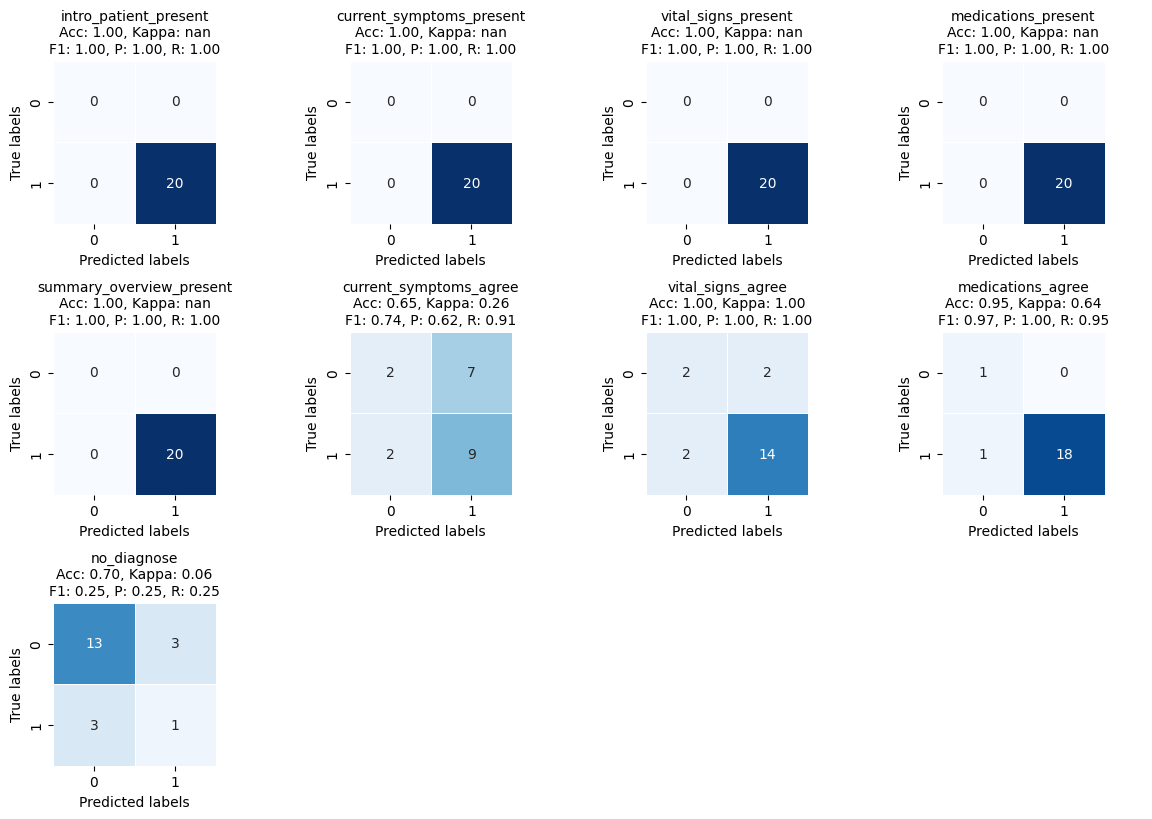

/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:730: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Libra

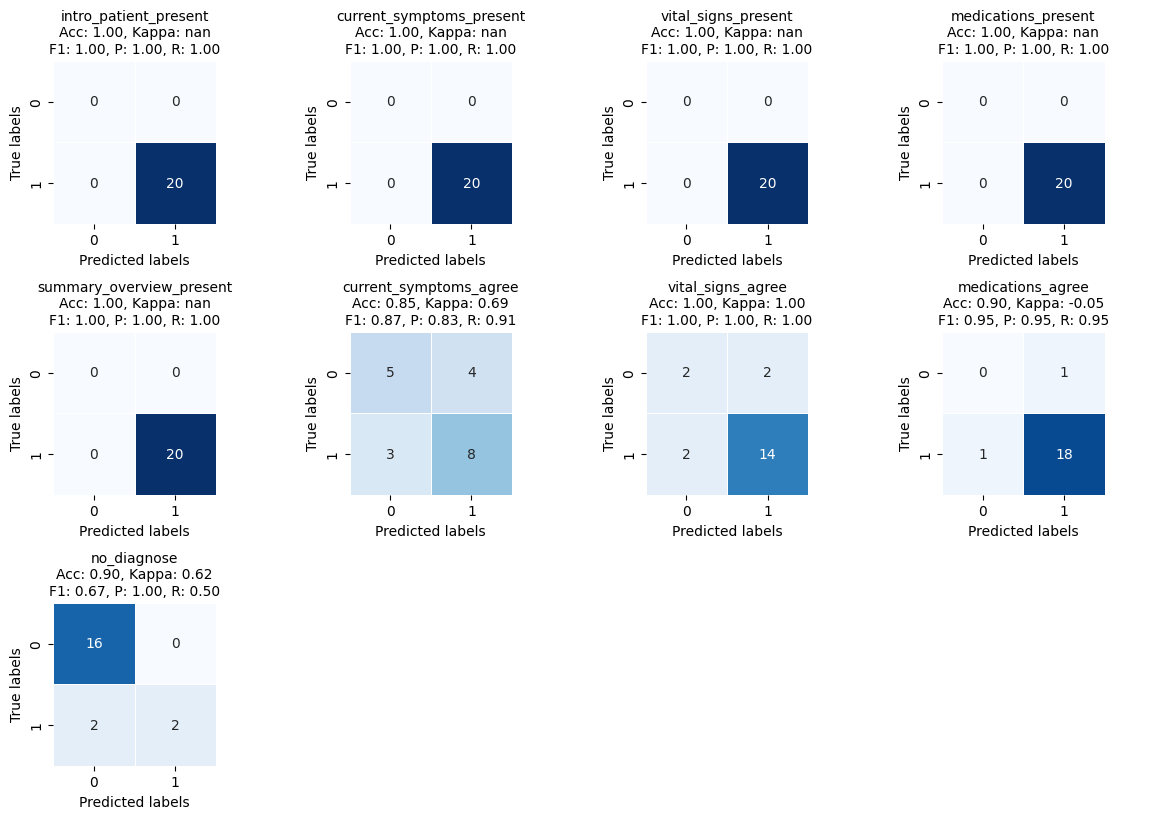

In [5]:
def calculate_metrics(data_true: pd.DataFrame, data_pred: pd.DataFrame, columns: list[str]):
    metrics = {}
    for col in columns:
        tp = np.sum((data_true[col] == 1) & (data_pred[col] == 1))
        tn = np.sum((data_true[col] == 0) & (data_pred[col] == 0))
        fp = np.sum((data_true[col] == 0) & (data_pred[col] == 1))
        fn = np.sum((data_true[col] == 1) & (data_pred[col] == 0))
        accuracy = accuracy_score(data_true[col], data_pred[col])
        kappa = cohen_kappa_score(data_true[col], data_pred[col])
        precision = precision_score(data_true[col], data_pred[col], zero_division=0)
        recall = recall_score(data_true[col], data_pred[col], zero_division=0)
        f1 = f1_score(data_true[col], data_pred[col], zero_division=0)

        metrics[col] = {
            'conf_matrix': [[tn, fp], [fn, tp]],
            'accuracy': accuracy,
            'kappa': kappa,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    return metrics


def plot_confusion_matrices(metrics, nrows: int, ncols: int):
    # figure out the color scale first
    max_val = max([np.array(v['conf_matrix']).max() for v in metrics.values()])
    min_val = min([np.array(v['conf_matrix']).min() for v in metrics.values()])

    size = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size * ncols, size * nrows))
    # plt.suptitle(main_title)
    axes = axes.flatten()

    for i, (col, data) in enumerate(metrics.items()):
        sns.heatmap(
            data['conf_matrix'],
            annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', ax=axes[i], cbar=False,
            vmin=min_val, vmax=max_val
        )
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')
        axes[i].set_title(
            f'{col}\nAcc: {data["accuracy"]:.2f}, Kappa: {data["kappa"]:.2f}\nF1: {data["f1"]:.2f}, P: {data["precision"]:.2f}, R: {data["recall"]:.2f}',
            fontsize=10,
        )

    # Hide any unused axes if there are any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, axes

# Example usage
for llm_data in [llm_data_start, llm_data_end]:
    metrics = calculate_metrics(human_data, llm_data, feature_columns_order)
    metrics_to_display = list(metrics.keys())  # all
    # metrics_to_display = ['current_symptoms_agree', "no_diagnose"]  # select ones
    columns_per_row = 4
    nrows = math.ceil(len(metrics_to_display) / columns_per_row)
    ncols = columns_per_row

    fig, axes = plot_confusion_matrices(
        {k: v for k, v in metrics.items() if k in metrics_to_display},
        nrows, ncols,
    )
    plt.show()

/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:730: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Libra

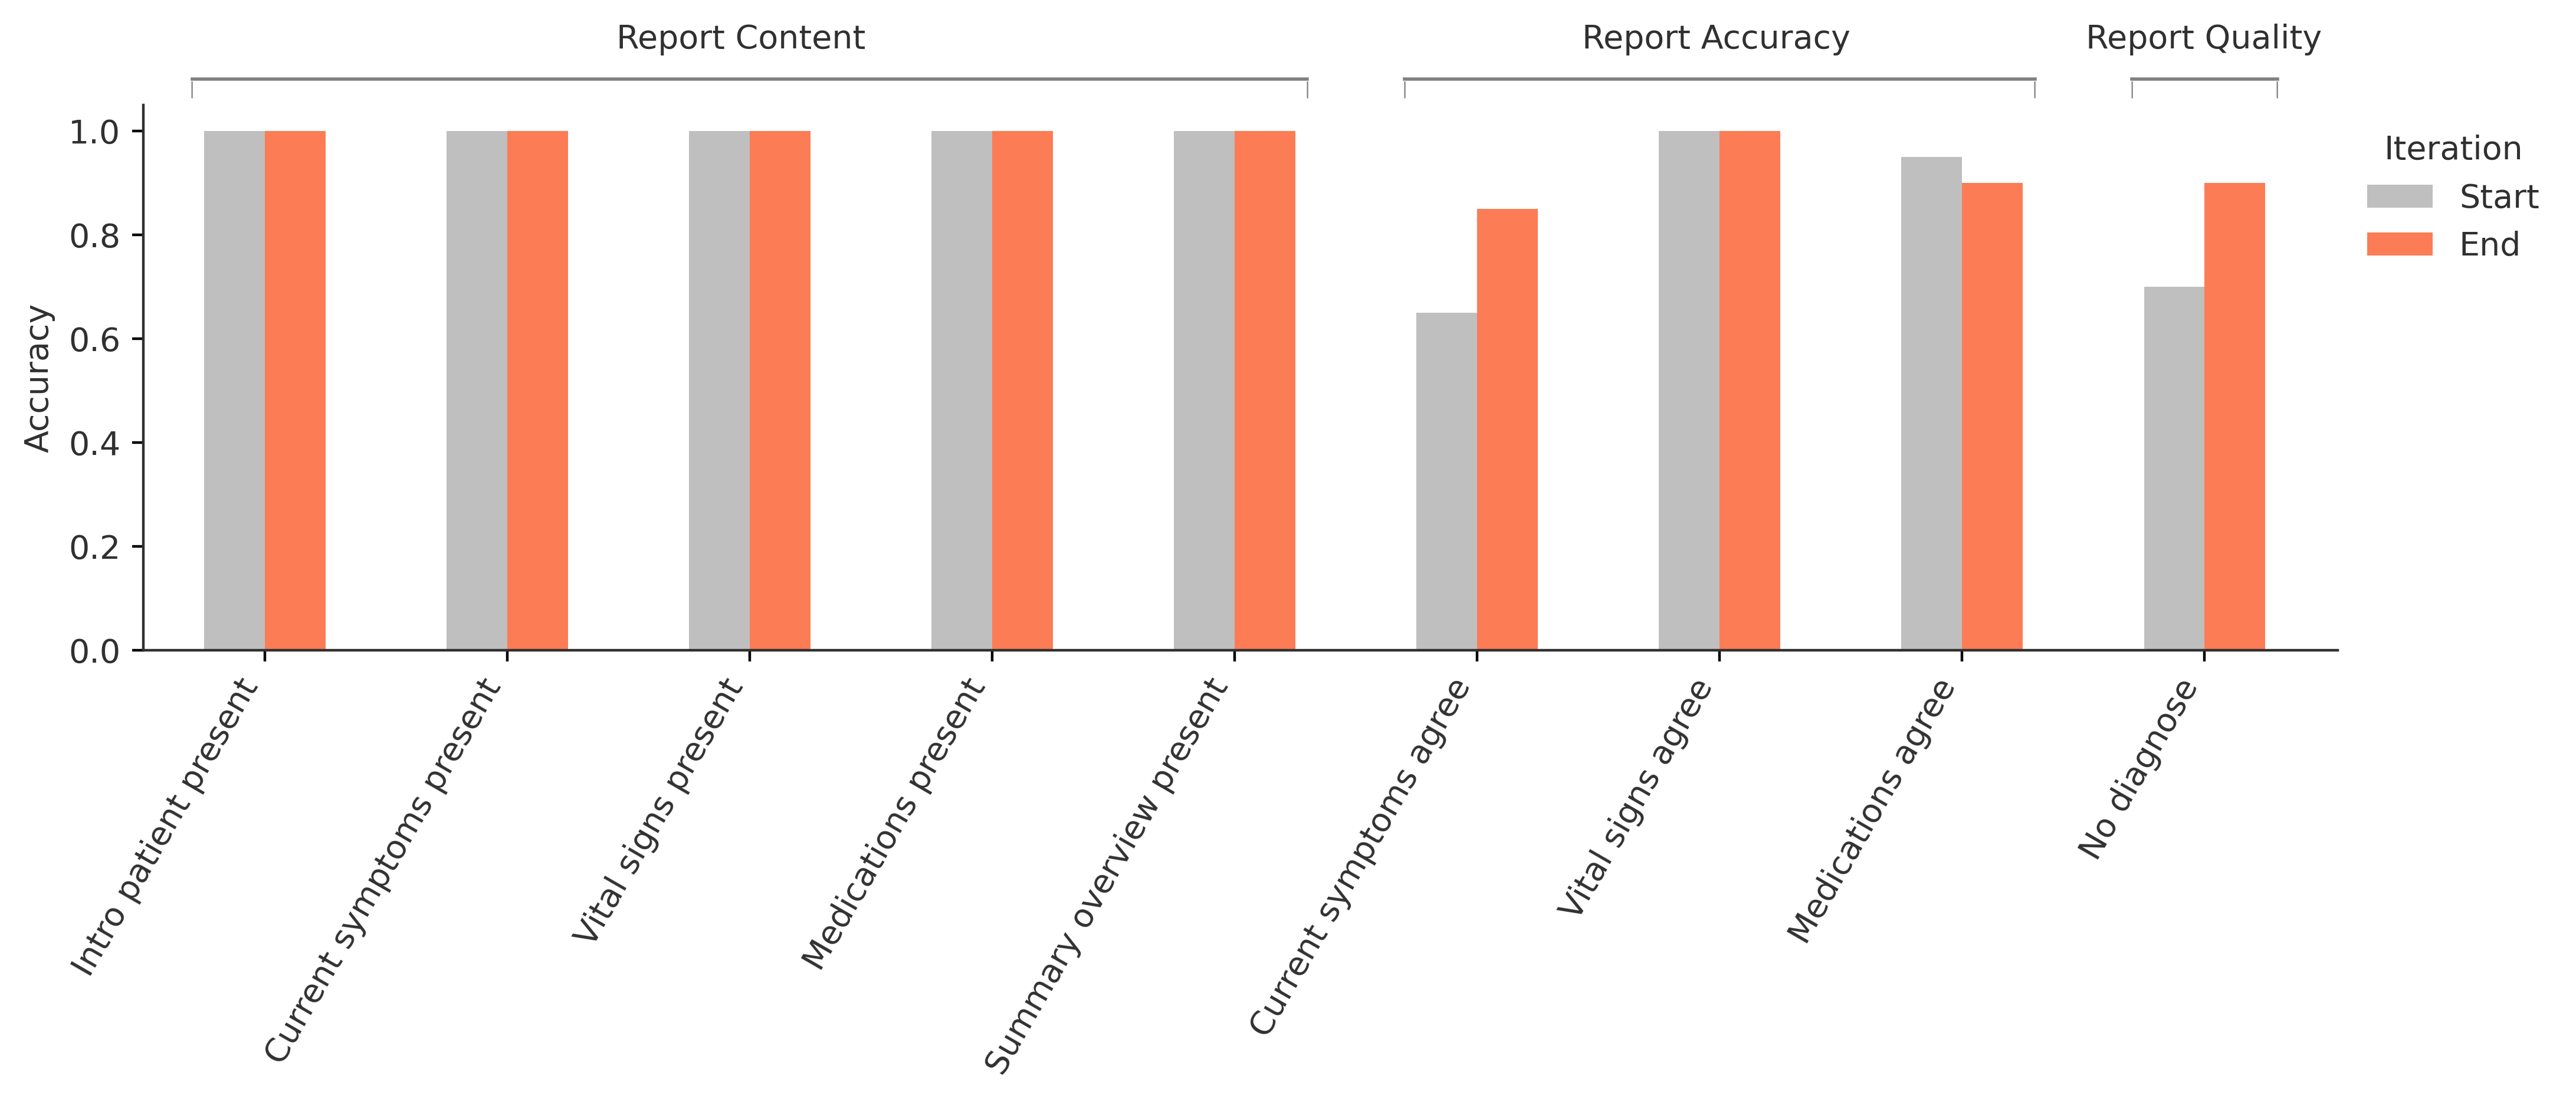

In [18]:
# now, the money plot: bar plot of llm_data_start and llm_data_end side-by-side,
# along all metrics (categorized)

metric_to_plot = "accuracy"  # choose from "accuracy", "kappa", "precision", "recall", "f1"

all_metrics = []
for iteration, llm_data in {"Start": llm_data_start, "End": llm_data_end}.items():
    metrics = pd.DataFrame(calculate_metrics(human_data, llm_data, feature_columns_order)).T
    metrics.index.name = "criteria"
    metrics = metrics.reset_index()
    metrics["iteration"] = iteration
    all_metrics.append(metrics)

df_plot_metric = pd.concat(all_metrics)
df_plot_metric["category"] = df_plot_metric["criteria"].map(criteria_to_category_map)
df_plot_metric = df_plot_metric[["iteration", "category", "criteria", metric_to_plot]]
# display(df_plot_metric)

# calculate average by category and iteration
df_plot_metric_avg = df_plot_metric.groupby(["iteration", "category"])[metric_to_plot].mean().reset_index()
# display(df_plot_metric_avg)

# now plot metric by question
fig, ax = plt.subplots(figsize=(12, 3), dpi=400)

df_plot = (
    df_plot_metric
    .pivot(index="criteria", columns="iteration", values=metric_to_plot)[["Start", "End"]]
    .reindex(feature_columns_order)
)

df_plot.plot(kind="bar", ax=ax, color=["#bfbfbf", "#fc7c55"])
# df_plot.plot(kind="bar", ax=ax, color=["#bfbfbf", "#ffffff"])

# styling
default_color = "#303030"
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Iteration")
ax.get_legend().get_frame().set_linewidth(0.0)
plt.setp(plt.gca().get_legend().get_title(), color=default_color)
plt.setp(plt.gca().get_legend().get_texts(), color=default_color)

# set default color for x-axis labels, y-axis labels, ticks, and spines
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_color(default_color)
plt.gca().spines['bottom'].set_color(default_color)
plt.gca().spines['left'].set_color(default_color)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel(metric_to_plot.capitalize(), color=default_color)
plt.xlabel("", color=default_color)

# capitialize the xticks
plt.xticks(ticks=range(len(feature_columns_order)), labels=[x.replace("_", " ").capitalize() for x in feature_columns_order], rotation=60, ha="right")
plt.xlim(-0.5, len(feature_columns_order) - 0.45)
plt.ylim(0, 1.05)

# Add criteria group labels
for i, (group, items) in enumerate(question_categories.items()):
    start_index = feature_columns_order.index(items[0])
    end_index = feature_columns_order.index(items[-1])
    group_name_formatted = " ".join([x.capitalize() for x in group.split("_")])
    ax.annotate(group_name_formatted, xy=((start_index + end_index) / 18 + 0.05, 1.12), xycoords='axes fraction', ha='center', va='center', fontsize=10, color=default_color, annotation_clip=False)

    # draw a line from the start to the end
    line_height = 1.1
    extra_margin = 0.3
    ax.plot([start_index - extra_margin, end_index + extra_margin], [line_height, line_height], color='gray', lw=1, clip_on=False)

    # add small brackets at the start and end
    for x in [start_index - extra_margin, end_index + extra_margin]:
        ax.annotate("|", xy=(x, line_height - 0.02), xycoords='data', ha='center', va='center', fontsize=5, color='gray', annotation_clip=False)

plt.show()